In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import joblib


In [17]:
data = pd.read_csv('D:\data.csv', encoding='Latin-1')

In [8]:
data.head(5)

,label,url
0,0,diaryofagameaddict.com
1,0,espdesign.com.au
2,0,iamagameaddict.com
3,0,kalantzis.net
4,0,slightlyoffcenter.net


In [18]:
X_train, X_test, y_train, y_test = train_test_split(data['url'], data['label'], test_size=0.2, random_state=42)


In [19]:
pipeline = make_pipeline(CountVectorizer(), MultinomialNB())

In [20]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [21]:
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]  


In [22]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [23]:
cv_scores = cross_val_score(pipeline, data['url'], data['label'], cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())


Cross-validation scores: [0.96029396 0.95889075 0.95081636 0.89917116 0.90245208]
Mean CV accuracy: 0.9343248604570566


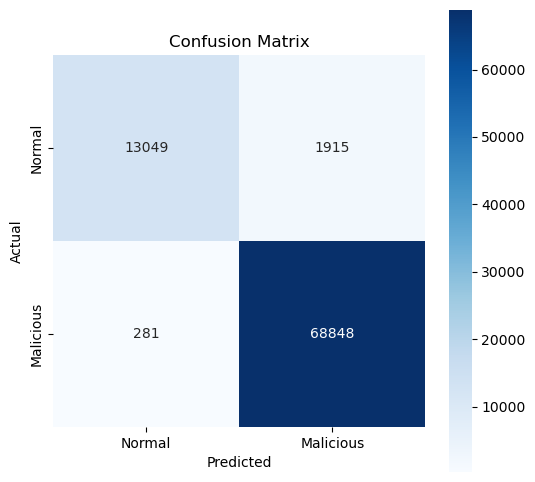

In [24]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', square=True, cmap='Blues',
            xticklabels=['Normal', 'Malicious'],
            yticklabels=['Normal', 'Malicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [25]:
vectorizer = pipeline.named_steps['countvectorizer']
feature_names = vectorizer.get_feature_names_out()
coefs_with_fns = sorted(zip(pipeline.named_steps['multinomialnb'].coef_[0], feature_names), reverse=True)
top_words = pd.DataFrame(coefs_with_fns, columns=['coef', 'word']).head(20)

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


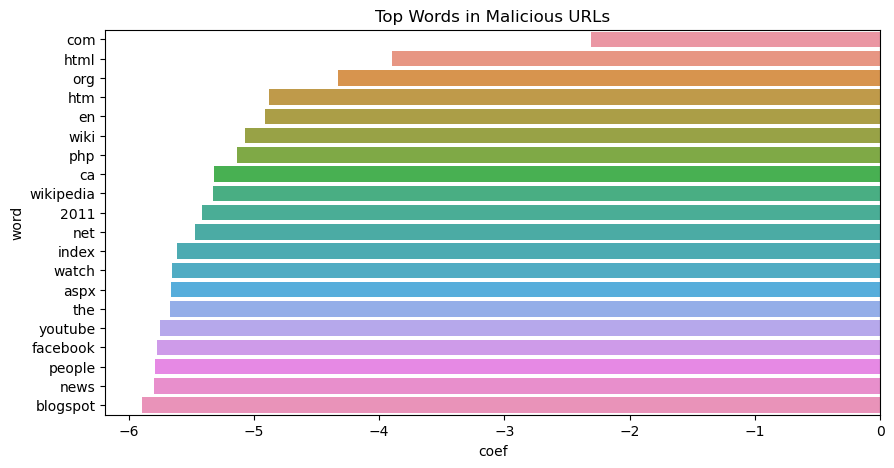

In [26]:
plt.figure(figsize=(10, 5))
sns.barplot(x=top_words['coef'], y=top_words['word'])
plt.title('Top Words in Malicious URLs')
plt.show()

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

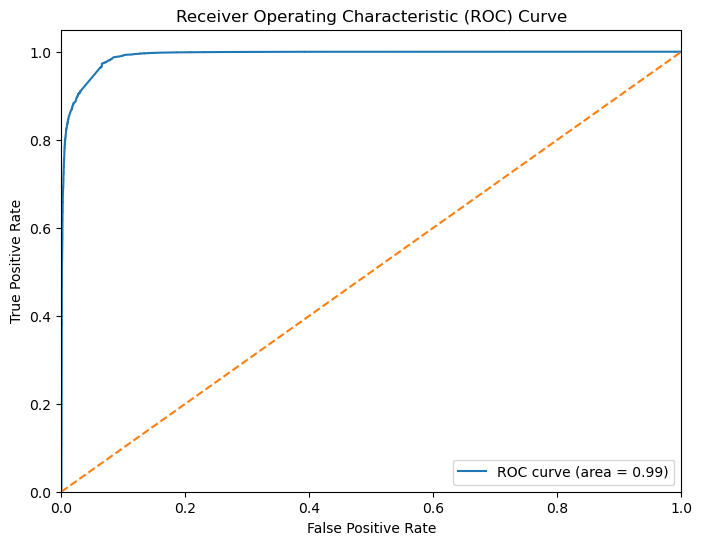

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

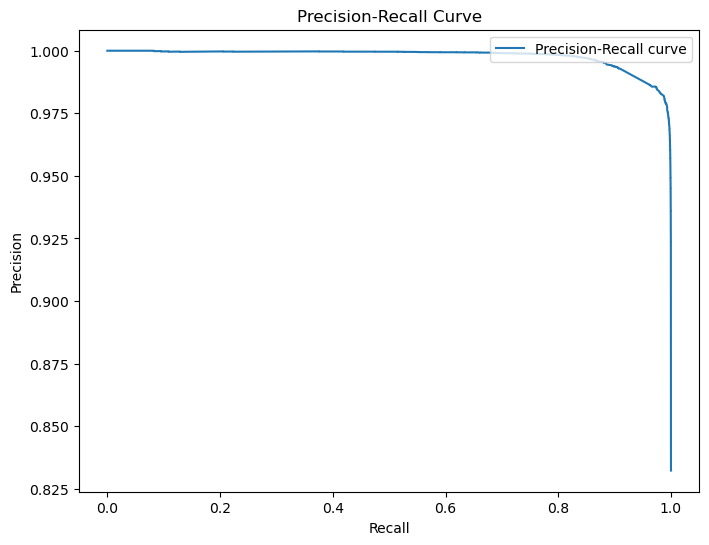

In [29]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

In [30]:
word_importances = dict(zip(feature_names, pipeline.named_steps['multinomialnb'].coef_[0]))
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_importances)

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


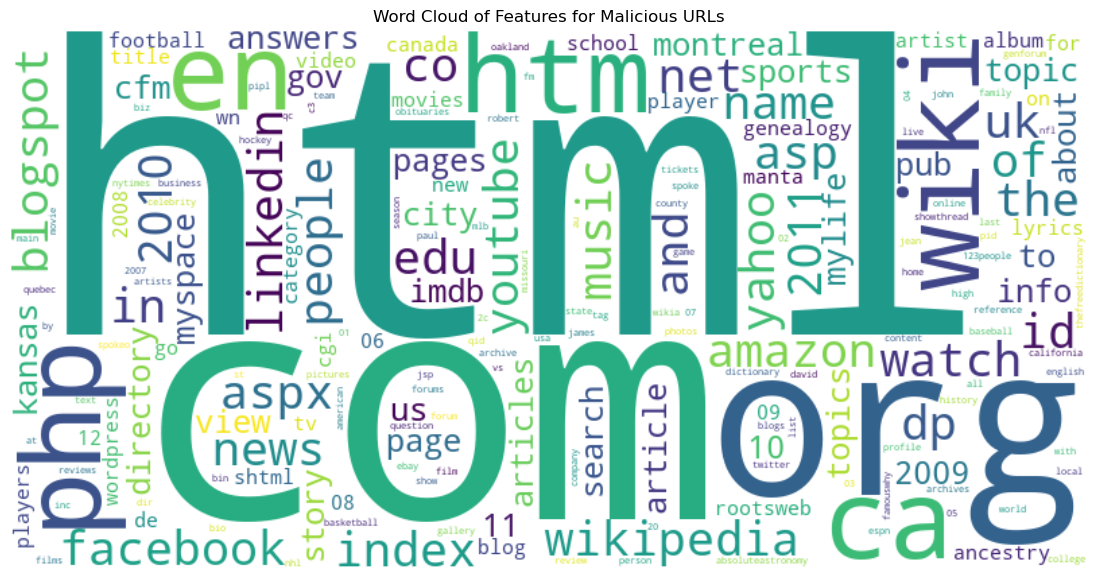

In [31]:
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Features for Malicious URLs')
plt.show()

In [32]:
data['url_length'] = data['url'].apply(len)

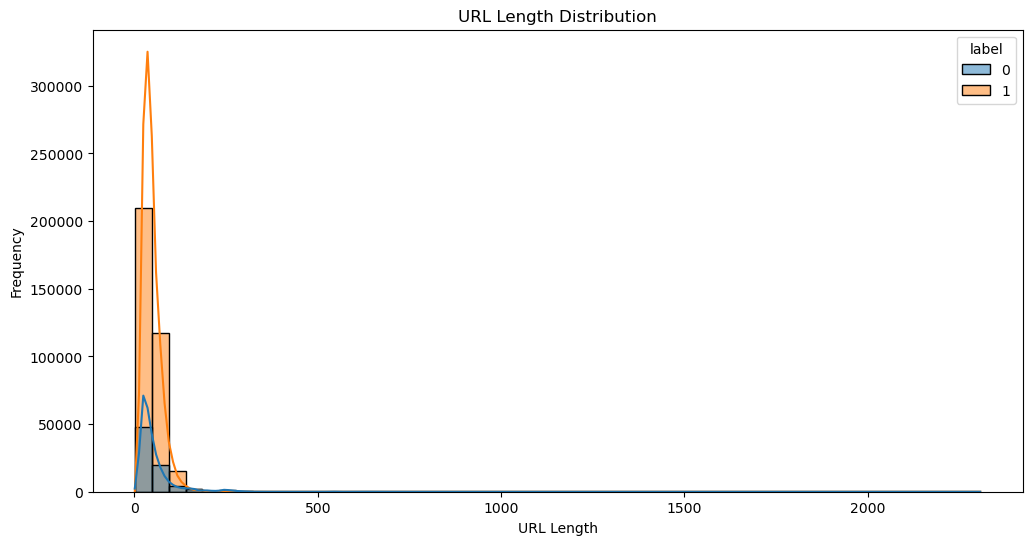

In [33]:
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='url_length', hue='label', bins=50, kde=True)
plt.title('URL Length Distribution')
plt.xlabel('URL Length')
plt.ylabel('Frequency')
plt.show()

In [34]:
features = vectorizer.get_feature_names_out()
coefs = pipeline.named_steps['multinomialnb'].coef_[0]
importances = np.exp(coefs)

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [35]:
indices_normal = np.argsort(importances)[:10]
indices_malicious = np.argsort(importances)[-10:]
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 0, 'Importance')

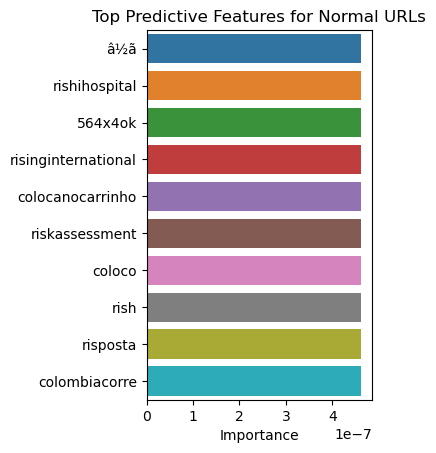

In [36]:
plt.subplot(1, 2, 1)
sns.barplot(x=importances[indices_normal], y=features[indices_normal])
plt.title('Top Predictive Features for Normal URLs')
plt.xlabel('Importance')

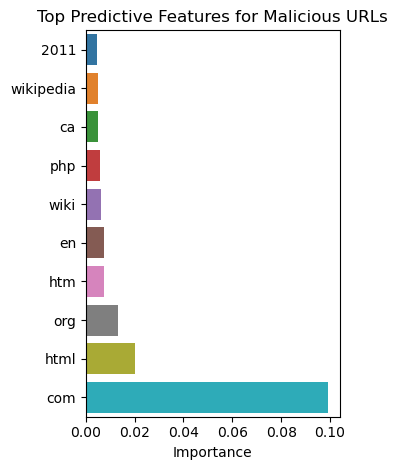

In [37]:
plt.subplot(1, 2, 2)
sns.barplot(x=importances[indices_malicious], y=features[indices_malicious])
plt.title('Top Predictive Features for Malicious URLs')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [38]:
joblib.dump(pipeline, 'url_classifier.joblib')

['url_classifier.joblib']